In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
import sys
from decimal import Decimal
sys.path.append("..")
import vvkernels as vvk
import vvmeans as vvm
import vvlikelihood as vvll
from vfield import VField
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sample_x = torch.linspace(0, 1, 300)
k = 100
N = sample_x.shape[0]
indices = torch.randperm(N)[:k]
train_x = sample_x[indices]


train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
def g_theta(theta):
    return torch.linspace(0, 1, 10)

In [3]:



x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)
        #self.covar_module = gpytorch.kernels.MultitaskKernel(
      #      gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
     #   )
        self.covar_module = vvk.TensorProductKernel(gpytorch.kernels.RBFKernel(), a[0,0], a[1,0], a[1,1], num_tasks = 2, rank =1,  task_covar_prior=None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    
#f_target = torch.ones(v.shape[0] * tpk.num_tasks, tpk.num_tasks)



likelihood = vvll.TensorProductLikelihood(x_train, num_tasks = 2)



model = MultitaskGPModel(x_train, y_train, likelihood)

In [4]:
training_iter = 100
model.train()
likelihood.train()



agg_data = y_train


# for param_name, param in model.named_parameters():
#     print(f'Parameter name: {param_name:42}') #' value = {param.item()}')
#     print(param)
optimizer = torch.optim.Adam(model.parameters(),  lr=0.1)  # Includes GaussianLikelihood parameters
g_theta1 = x_train
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(g_theta1)
    #loss = -mll(output, agg_data)
    loss = -likelihood.get_hpll(agg_data, g_theta1, model.mean_module, model.covar_module)
    loss.backward()
    #print((gpytorch.logdet(model.covar_module.forward(g_theta1, g_theta1.t()))))
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 143.801
Iter 2/100 - Loss: 137.957
Iter 3/100 - Loss: 132.175
Iter 4/100 - Loss: 126.563
Iter 5/100 - Loss: 121.069
Iter 6/100 - Loss: 115.541
Iter 7/100 - Loss: 109.838
Iter 8/100 - Loss: 103.907
Iter 9/100 - Loss: 97.721
Iter 10/100 - Loss: 91.241
Iter 11/100 - Loss: 84.412
Iter 12/100 - Loss: 77.213
Iter 13/100 - Loss: 69.708
Iter 14/100 - Loss: 62.064
Iter 15/100 - Loss: 54.552
Iter 16/100 - Loss: 47.491
Iter 17/100 - Loss: 41.035
Iter 18/100 - Loss: 35.042
Iter 19/100 - Loss: 29.595
Iter 20/100 - Loss: 25.313
Iter 21/100 - Loss: 22.653
Iter 22/100 - Loss: 21.199
Iter 23/100 - Loss: 20.110
Iter 24/100 - Loss: 18.818
Iter 25/100 - Loss: 17.055
Iter 26/100 - Loss: 14.674
Iter 27/100 - Loss: 11.628
Iter 28/100 - Loss: 8.106
Iter 29/100 - Loss: 4.757
Iter 30/100 - Loss: 2.658
Iter 31/100 - Loss: 2.187
Iter 32/100 - Loss: 2.403
Iter 33/100 - Loss: 2.734
Iter 34/100 - Loss: 3.306
Iter 35/100 - Loss: 4.086
Iter 36/100 - Loss: 4.713
Iter 37/100 - Loss: 4.881
Iter 38/100 

In [5]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42}') #' value = {param.item()}')
    print(param)

Parameter name: likelihood.task_noise_covar_factor        
Parameter containing:
tensor([[-0.0318],
        [ 0.0872]], requires_grad=True)
Parameter name: likelihood.raw_noise                      
Parameter containing:
tensor([-3.1596], requires_grad=True)
Parameter name: mean_module.base_means.0.constant         
Parameter containing:
tensor([-0.0633], requires_grad=True)
Parameter name: mean_module.base_means.1.constant         
Parameter containing:
tensor([0.3802], requires_grad=True)
Parameter name: covar_module.chol_11                      
Parameter containing:
tensor(1.0076, requires_grad=True)
Parameter name: covar_module.chol_22                      
Parameter containing:
tensor(0.9167, requires_grad=True)
Parameter name: covar_module.chol_21                      
Parameter containing:
tensor(-0.0461, requires_grad=True)
Parameter name: covar_module.task_covar_module.covar_factor
Parameter containing:
tensor([[-0.5720],
        [-1.7119]], requires_grad=True)
Parameter name

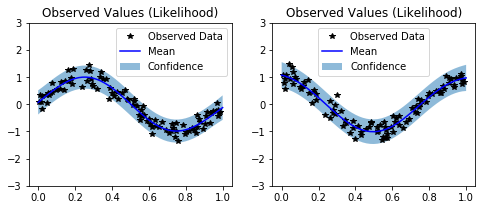

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [7]:
class param_opti(nn.Module):
    def __init__(self, _theta2,k):
        super(param_opti, self).__init__()
        N = _theta2.shape[0]
        indices = torch.randperm(N)[:k]
        sampled_values= _theta2[indices]
        self.g_theta2 = nn.Parameter(sampled_values)
        
    def forward(self):
        
        return (self.g_theta2)

In [8]:
def conduct_param_opti(x, training_iter):
    f_target = torch.zeros(2,1)
    f_target[0] = 0.5 *torch.sqrt(Tensor([2.]))
    f_target[1] = 0.5 * torch.sqrt(Tensor([2.]))
    #f_target = f_target.reshape(2,1)



    
    _par = param_opti(sample_x,20)

    optimizer = torch.optim.Adam(_par.parameters(), lr=0.1)
    
    for i in range(training_iter):
        optimizer.zero_grad()
        g_theta2 = _par.forward()
        loss = -likelihood.get_ell(agg_data,f_target,x, g_theta1, g_theta2, model.mean_module, model.covar_module)
        loss.backward(retain_graph=True)
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
    print(g_theta2)
    return loss

In [9]:
x = Tensor([1./6.])
x = x.reshape(1,1)
conduct_param_opti(x,100)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 1/100 - Loss: 502743.656
Iter 2/100 - Loss: 78730.609
Iter 3/100 - Loss: 974866.625
Iter 4/100 - Loss: 178402.594
Iter 5/100 - Loss: 131982.891
Iter 6/100 - Loss: 272783.656
Iter 7/100 - Loss: 119093.211
Iter 8/100 - Loss: 125025.164
Iter 9/100 - Loss: 124071.086
Iter 10/100 - Loss: 123485.102
Iter 11/100 - Loss: 122479.359
Iter 12/100 - Loss: 113273.945


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 13/100 - Loss: 112617.844
Iter 14/100 - Loss: 112160.922
Iter 15/100 - Loss: 111822.531
Iter 16/100 - Loss: 111354.438
Iter 17/100 - Loss: 110965.703
Iter 18/100 - Loss: 110508.484
Iter 19/100 - Loss: 110051.141
Iter 20/100 - Loss: 109433.188
Iter 21/100 - Loss: 108995.297
Iter 22/100 - Loss: 108581.422
Iter 23/100 - Loss: 108306.328
Iter 24/100 - Loss: 108018.477
Iter 25/100 - Loss: 107758.922
Iter 26/100 - Loss: 107378.117
Iter 27/100 - Loss: 107122.391
Iter 28/100 - Loss: 106759.219
Iter 29/100 - Loss: 106670.695
Iter 30/100 - Loss: 106501.617
Iter 31/100 - Loss: 106402.906
Iter 32/100 - Loss: 106327.461
Iter 33/100 - Loss: 106143.688
Iter 34/100 - Loss: 105899.914
Iter 35/100 - Loss: 105833.938
Iter 36/100 - Loss: 105677.773
Iter 37/100 - Loss: 105743.570
Iter 38/100 - Loss: 105549.438
Iter 39/100 - Loss: 105655.648
Iter 40/100 - Loss: 105378.016
Iter 41/100 - Loss: 105283.375
Iter 42/100 - Loss: 105173.305
Iter 43/100 - Loss: 105093.109
Iter 44/100 - Loss: 105090.273
Iter 45/

tensor([[103370.0859]], grad_fn=<NegBackward>)

In [10]:
class design_opti(nn.Module):
    def __init__(self, _x):
        super(design_opti, self).__init__()
        self.x_design = nn.Parameter(_x)
        
    def forward(self):
        return self.x_design

In [11]:
def conduct_design_opti(training_iter_out, training_iter_in):
    x = Tensor([0.5])
    x = x.reshape(1,1)
    design = design_opti(x)
    optimizer = torch.optim.Adam(design.parameters(), lr=0.1)
    for i in range(training_iter_out):
        optimizer.zero_grad()
        x = design.forward()
        loss2 = conduct_param_opti(x,training_iter_in)
        loss2.backward(retain_graph=True)
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss2.item()))
        optimizer.step()
    
    print(x)
    

In [12]:
conduct_design_opti(10, 50)

Iter 1/50 - Loss: 14441556.000
Iter 2/50 - Loss: 1804399.125
Iter 3/50 - Loss: 1603129.750
Iter 4/50 - Loss: 1647851.375
Iter 5/50 - Loss: 3552780.500
Iter 6/50 - Loss: 3517534.500
Iter 7/50 - Loss: 3452640.750
Iter 8/50 - Loss: 3289574.250
Iter 9/50 - Loss: 3313603.750
Iter 10/50 - Loss: 3322417.000
Iter 11/50 - Loss: 3326325.750
Iter 12/50 - Loss: 3314937.500
Iter 13/50 - Loss: 3316042.750
Iter 14/50 - Loss: 3309244.500
Iter 15/50 - Loss: 3313026.000
Iter 16/50 - Loss: 3316109.250
Iter 17/50 - Loss: 3317527.250
Iter 18/50 - Loss: 3317258.250
Iter 19/50 - Loss: 3321665.750
Iter 20/50 - Loss: 3320069.750
Iter 21/50 - Loss: 3319640.250
Iter 22/50 - Loss: 3320133.250
Iter 23/50 - Loss: 3317028.000
Iter 24/50 - Loss: 3317286.000
Iter 25/50 - Loss: 3317684.250
Iter 26/50 - Loss: 3313410.500
Iter 27/50 - Loss: 3310563.750
Iter 28/50 - Loss: 3310037.250
Iter 29/50 - Loss: 3310275.500
Iter 30/50 - Loss: 3309219.750
Iter 31/50 - Loss: 3306931.750
Iter 32/50 - Loss: 3305618.750
Iter 33/50 - Los

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 1]], which is output 0 of ViewBackward, is at version 50; expected version 49 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
vf = VField()
sample_size = 10
v = torch.zeros(sample_size,2)
loc = torch.zeros(sample_size,2)
for i in range(sample_size):
    loc[i] = Tensor(np.random.sample((2)))
    v[i] = Tensor(vf(loc[i]))
    
test_size = 5
test_x = torch.zeros(test_size,2)
for i in range(test_size):
    test_x[i] = Tensor(np.random.sample((2)))

In [ ]:
test_x = Tensor([[0.2376]])
predictions = likelihood(model(test_x))
mean = predictions.mean
lower, upper = predictions.confidence_region()

In [ ]:
print(mean)

In [ ]:
print(lower)
print(upper)
f_target = torch.zeros(2,1)
f_target[0] = 0.5 *torch.sqrt(Tensor([2.]))
f_target[1] = 0.5 * torch.sqrt(Tensor([2.]))
print(f_target)